In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, RegressorMixin

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = "SPY_section_1.csv"
df = pd.read_csv(file_path)

# start to nov 2001 (dot com crash)
# not bad
# df = df.iloc[:2228]

# nov 01 to june 2009
# not bad
# df = df.iloc[2228:4135]

# june 2009 to april 2020
# ass
# df = df.iloc[4135:6862]

# april 2020 to most recent
# ass
# df = df.iloc[6862:]


# Convert the "Date" column to datetime
# df["Date"] = pd.to_datetime(df["Date"], format='%Y/%m/%d')

# # Sort the data by date in ascending order
# df = df.sort_values(by="Date")

# # Get the earliest and latest dates
# earliest_date = df["Date"].min()
# latest_date = df["Date"].max()

# print("Earliest Date:", earliest_date)
# print("Latest Date:", latest_date)


In [3]:
# Adding SMA as part of the feature test
short_term_period = 20
medium_term_period = 50
long_term_period = 200

# Compute the SMAs
df['SMA_20'] = df['Close'].rolling(window=short_term_period).mean()
df['SMA_50'] = df['Close'].rolling(window=medium_term_period).mean()
df['SMA_200'] = df['Close'].rolling(window=long_term_period).mean()

df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()  # Short-term EMA
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()  # Medium-term EMA
df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()  # Long-term EMA

df = df.dropna()

In [4]:
feature_columns = ["Open", "High", "Low", "Close", "Volume"]  
dates = df["Date"]
# if "Open" and "High" and "Low" and "Close" and "Volume" in df.columns:
#     df = df[feature_columns]


In [5]:

# scaler = StandardScaler()
# scaler = MinMaxScaler()
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Day", "Weekday", "Week", "Month", "Year"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200", "Non_Linear_Trend"]
feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Non_Linear_Trend", "SMA_20", "SMA_50", "EMA_10", "EMA_50"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Non_Linear_Trend"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_200", "EMA_10"]
X = df[feature_columns]

# Split data
train_size = int(X.shape[0] * 0.7)
val_size = int(X.shape[0] * 0.15)

# Initialize scaler
scaler = MinMaxScaler()
# scaler = RobustScaler()

# Split data into train, validation, and test
temp_train = X[:train_size]
temp_val = X[train_size:train_size + val_size]
temp_test = X[train_size + val_size:]

temp_train = temp_train[feature_columns]
temp_val = temp_val[feature_columns]
temp_test = temp_test[feature_columns]

# Fit and transform for train, transform for validation and test
temp_train = scaler.fit_transform(temp_train)
temp_val = scaler.transform(temp_val)
temp_test = scaler.transform(temp_test)

# Convert NumPy arrays back to DataFrames
temp_train = pd.DataFrame(temp_train, columns=feature_columns)
temp_val = pd.DataFrame(temp_val, columns=feature_columns)
temp_test = pd.DataFrame(temp_test, columns=feature_columns)

# Concatenate the data
X_scaled = pd.concat([temp_train, temp_val, temp_test], axis=0)

# Split sequentially
X_train = X_scaled[:train_size]
X_val = X_scaled[train_size:train_size + val_size]
X_test = X_scaled[train_size + val_size:]

# Print sizes to confirm
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 1421, Val: 304, Test: 305


In [6]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

In [7]:

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
test_dataset = TensorDataset(X_test_tensor, X_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [8]:
# # Check if CUDA is available and print the device being used
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# class Encoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim):
#         super(Encoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(64, encoding_dim)
#         )

#     def forward(self, x):
#         return self.encoder(x)

# class Decoder(nn.Module):
#     def __init__(self, encoding_dim, input_dim):
#         super(Decoder, self).__init__()
#         self.decoder = nn.Sequential(
#             nn.Linear(encoding_dim, 64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(64, 128),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, input_dim)
#         )

#     def forward(self, x):
#         return self.decoder(x)

    
# # Define input dimensions
# input_dim = X_train.shape[1]

# # Model file paths
# encoder_model_file = './autoencoder_trials/encoder.pth'
# decoder_model_file = './autoencoder_trials/decoder.pth'

# # Hyperparameters
# encoding_dim = 8
# learning_rate = 0.001
# epochs = 50
# batch_size = 8
# patience = 5

# # Check if the model files exist
# if os.path.exists(encoder_model_file) and os.path.exists(decoder_model_file):
#     print("Model files exist. Loading the models...")
#     encoder = Encoder(input_dim, encoding_dim).to(device)
#     decoder = Decoder(encoding_dim, input_dim).to(device)
#     encoder.load_state_dict(torch.load(encoder_model_file))
#     decoder.load_state_dict(torch.load(decoder_model_file))
# else:
#     print("Model files do not exist. Training new models...")

#     # Initialize the encoder and decoder models
#     encoder = Encoder(input_dim, encoding_dim).to(device)
#     decoder = Decoder(encoding_dim, input_dim).to(device)
#     optimizer_encoder = optim.Adam(encoder.parameters(), lr=learning_rate)
#     optimizer_decoder = optim.Adam(decoder.parameters(), lr=learning_rate)
#     criterion = nn.MSELoss()

#     # Track training loss
#     encoder_losses = []
#     decoder_losses = []

#     # Train the Encoder separately
#     encoder.train()
#     best_val_loss = float('inf')
#     patience_counter = 0
#     for epoch in range(epochs):
#         epoch_loss = 0
#         dataloader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(X_train, dtype=torch.float32).to(device)), batch_size=batch_size, shuffle=True, num_workers=0)
#         for i, (batch_X, _) in enumerate(dataloader):
#             batch_X = batch_X.to(device)
#             optimizer_encoder.zero_grad()
#             encoded = encoder(batch_X)
#             # Pass the encoded output through the decoder
#             decoded = decoder(encoded)
#             # Calculate loss between decoder output and original input
#             loss = criterion(decoded, batch_X)
#             loss.backward()
            
#             optimizer_encoder.step()
#             optimizer_encoder.zero_grad()
            
#             epoch_loss += loss.item()
#         avg_loss = epoch_loss / len(dataloader)
#         encoder_losses.append(avg_loss)
#         print(f"Epoch [{epoch+1}/{epochs}], Encoder Loss: {avg_loss:.4f}")

#         # Validation loss
#         encoder.eval()
#         decoder.eval()
#         with torch.no_grad():
#             val_encoded = encoder(torch.tensor(X_val, dtype=torch.float32).to(device))
#             val_decoded = decoder(val_encoded)
#             val_loss = criterion(val_decoded, torch.tensor(X_val, dtype=torch.float32).to(device)).item()
#         print(f"Validation Loss: {val_loss:.4f}")

#         # Early stopping
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             patience_counter = 0
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print("Early stopping triggered.")
#                 break

#     # Train the Decoder separately
#     encoded_train = encoder(torch.tensor(X_train, dtype=torch.float32).to(device)).detach()
#     decoder.train()
#     best_val_loss = float('inf')
#     patience_counter = 0
#     for epoch in range(epochs):
#         epoch_loss = 0
#         dataloader = DataLoader(TensorDataset(encoded_train, torch.tensor(X_train, dtype=torch.float32).to(device)), batch_size=batch_size, shuffle=True, num_workers=0)
#         for i, (batch_X, batch_y) in enumerate(dataloader):
#             batch_X, batch_y = batch_X.to(device), batch_y.to(device)
#             optimizer_decoder.zero_grad()
#             outputs = decoder(batch_X)
#             # Calculate loss between decoder output and original input
#             loss = criterion(outputs, batch_y)
#             loss.backward()
            
#             optimizer_decoder.step()
#             optimizer_decoder.zero_grad()
            
#             epoch_loss += loss.item()
#         avg_loss = epoch_loss / len(dataloader)
#         decoder_losses.append(avg_loss)
#         print(f"Epoch [{epoch+1}/{epochs}], Decoder Loss: {avg_loss:.4f}")

#         # Validation loss
#         decoder.eval()
#         with torch.no_grad():
#             val_outputs = decoder(encoded_train)
#             val_loss = criterion(val_outputs, torch.tensor(X_train, dtype=torch.float32).to(device)).item()
#         print(f"Validation Loss: {val_loss:.4f}")

#         # Early stopping
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             patience_counter = 0
#         else:
#             patience_counter += 1
#             print("Early stopping counter:", patience_counter)
#             if patience_counter >= patience:
#                 print("Early stopping triggered.")
#                 break

#     # Save the trained models
#     os.makedirs('./autoencoder_trials', exist_ok=True)
#     # torch.save(encoder.state_dict(), encoder_model_file)
#     # torch.save(decoder.state_dict(), decoder_model_file)
#     print("Models trained and saved.")

# # Combine Encoder and Decoder to form the Autoencoder
# class Autoencoder(nn.Module):
#     def __init__(self, encoder, decoder):
#         super(Autoencoder, self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

# autoencoder = Autoencoder(encoder, decoder).to(device)
# autoencoder.eval()

# # Calculate reconstruction error on the test set
# with torch.no_grad():
#     reconstructed_test = autoencoder(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

# # Calculate Mean Squared Error (MSE)
# mse = np.mean((X_test - reconstructed_test) ** 2)
# print(f'Mean Squared Error (MSE): {mse}')

# # Calculate Mean Absolute Error (MAE)
# mae = np.mean(np.abs(X_test - reconstructed_test))
# print(f'Mean Absolute Error (MAE): {mae}')

# # Calculate Reconstruction Error Percentage
# # reconstruction_error = np.mean(np.square(X_test - reconstructed_test), axis=1)
# # reconstruction_error_percentage = np.mean(reconstruction_error) * 100
# # print(f'Reconstruction Error Percentage: {reconstruction_error_percentage}')

# reconstruction_error_percentage = (
#     np.mean(np.abs(X_test - reconstructed_test) / (np.abs(X_test) + 1e-8), axis=1) * 100
# )
# reconstruction_error_percentage_mean = np.mean(reconstruction_error_percentage)
# print(f'Reconstruction Error Percentage: {reconstruction_error_percentage_mean}')

# def calculate_index_error_percentage(index, X, reconstructed_X):
#     print(np.mean(np.abs(X[index] - reconstructed_X[index]) / (np.abs(X[index]) + 1e-8)) * 100)     


In [9]:
# import os
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# from torch.utils.data import DataLoader, TensorDataset

# # Check if CUDA is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Define Encoder
# class Encoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim, dropout_rate):
#         super(Encoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(64, encoding_dim)
#         )

#     def forward(self, x):
#         return self.encoder(x)

# # Define Decoder
# class Decoder(nn.Module):
#     def __init__(self, encoding_dim, input_dim, dropout_rate):
#         super(Decoder, self).__init__()
#         self.decoder = nn.Sequential(
#             nn.Linear(encoding_dim, 64),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(64, 128),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(128, input_dim)
#         )

#     def forward(self, x):
#         return self.decoder(x)

# def relative_euclidean_error(X, X_reconstructed):
#     return np.linalg.norm(X - X_reconstructed, axis=1) / np.linalg.norm(X, axis=1)

# class RelativeEuclideanError(nn.Module):
#     def forward(self, y_true, y_pred):
#         return torch.mean(torch.norm(y_true - y_pred, dim=1) / torch.norm(y_true, dim=1))

# # Define input dimensions
# input_dim = X_train.shape[1]

# # Model file paths
# encoder_model_file = './autoencoder_trials/encoder.pth'
# decoder_model_file = './autoencoder_trials/decoder.pth'

# # Hyperparameters
# encoding_dim = 5
# learning_rate = 0.0001
# dropout_rate = 0.0
# epochs = 750
# batch_size = 16
# patience = 30

# # Initialize models
# encoder = Encoder(input_dim, encoding_dim, dropout_rate).to(device)
# decoder = Decoder(encoding_dim, input_dim, dropout_rate).to(device)

# # Define optimizers and loss function
# optimizer_encoder = optim.Adam(encoder.parameters(), lr=learning_rate)
# optimizer_decoder = optim.Adam(decoder.parameters(), lr=learning_rate)
# # criterion = nn.MSELoss()
# criterion = RelativeEuclideanError()
# #use MAE
# # criterion = nn.L1Loss()

# # Add Gaussian noise to encoded representations to avoid overfitting
# def add_noise(encoded, noise_factor=0.01):
#     return encoded + noise_factor * torch.randn_like(encoded)

# # Train Encoder
# def train_encoder():
#     print("Training Encoder...")
#     encoder.train()
#     best_val_loss = float('inf')
#     patience_counter = 0
#     # clip_value = 1

#     for epoch in range(epochs):
#         epoch_loss = 0
#         dataloader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), 
#                                               torch.tensor(X_train, dtype=torch.float32).to(device)), 
#                                 batch_size=batch_size, shuffle=True, num_workers=0)

#         for batch_X, _ in dataloader:
#             batch_X = batch_X.to(device)
#             optimizer_encoder.zero_grad()
#             encoded = encoder(batch_X)
#             decoded = decoder(encoded)
#             loss = criterion(decoded, batch_X)
#             loss.backward()
            
#             # torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=clip_value)  # Option 1
#             # torch.nn.utils.clip_grad_value_(encoder.parameters(), clip_value=clip_value)  # Option 2

#             optimizer_encoder.step()
#             epoch_loss += loss.item()

#         avg_loss = epoch_loss / len(dataloader)
#         print(f"Epoch [{epoch+1}/{epochs}], Encoder Loss: {avg_loss:.4f}")

#         # Validation loss
#         encoder.eval()
#         decoder.eval()
#         with torch.no_grad():
#             val_encoded = encoder(torch.tensor(X_val, dtype=torch.float32).to(device))
#             val_decoded = decoder(val_encoded)
#             val_loss = criterion(val_decoded, torch.tensor(X_val, dtype=torch.float32).to(device)).item()
#         print(f"Validation Loss: {val_loss:.4f}")

#         # Early stopping
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             patience_counter = 0
#             torch.save(encoder.state_dict(), encoder_model_file)  # Save best model
#         else:
#             patience_counter += 1
#             print("Early stopping counter:", patience_counter)
#             if patience_counter >= patience:
#                 print("Early stopping triggered for encoder.")
#                 break

# # Train Decoder
# def train_decoder():
#     print("Training Decoder...")
#     encoder.eval()
#     encoded_train = encoder(torch.tensor(X_train, dtype=torch.float32).to(device)).detach()

#     decoder.train()
#     best_val_loss = float('inf')
#     patience_counter = 0
#     # clip_value = 1

#     for epoch in range(epochs):
#         epoch_loss = 0
#         dataloader = DataLoader(TensorDataset(encoded_train, torch.tensor(X_train, dtype=torch.float32).to(device)), 
#                                 batch_size=batch_size, shuffle=True, num_workers=0)

#         for batch_X, batch_y in dataloader:
#             batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
#             # Add Gaussian noise
#             noisy_batch_X = add_noise(batch_X)

#             optimizer_decoder.zero_grad()
#             outputs = decoder(noisy_batch_X)
#             loss = criterion(outputs, batch_y)
#             loss.backward()
            
#             # torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=clip_value)  # Option 1
#             # torch.nn.utils.clip_grad_value_(decoder.parameters(), clip_value=clip_value)  # Option 2
            
#             optimizer_decoder.step()
            
#             epoch_loss += loss.item()

#         avg_loss = epoch_loss / len(dataloader)
#         print(f"Epoch [{epoch+1}/{epochs}], Decoder Loss: {avg_loss:.4f}")

#         # Validation loss
#         decoder.eval()
#         with torch.no_grad():
#             val_encoded = encoder(torch.tensor(X_val, dtype=torch.float32).to(device))
#             val_decoded = decoder(val_encoded)
#             val_loss = criterion(val_decoded, torch.tensor(X_val, dtype=torch.float32).to(device)).item()
#         print(f"Validation Loss: {val_loss:.4f}")

#         # Early stopping
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             patience_counter = 0
#             torch.save(decoder.state_dict(), decoder_model_file)  # Save best model
#         else:
#             patience_counter += 1
#             print("Early stopping counter:", patience_counter)
#             if patience_counter >= patience:
#                 print("Early stopping triggered for decoder.")
#                 break

# # Train models if files do not exist
# if os.path.exists(encoder_model_file) and os.path.exists(decoder_model_file):
#     print("Model files exist. Loading the models...")
#     encoder.load_state_dict(torch.load(encoder_model_file))
#     decoder.load_state_dict(torch.load(decoder_model_file))
# else:
#     os.makedirs('./autoencoder_trials', exist_ok=True)
#     train_encoder()
#     train_decoder()

# # Combine Encoder and Decoder to form the Autoencoder
# class Autoencoder(nn.Module):
#     def __init__(self, encoder, decoder):
#         super(Autoencoder, self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

# # Load trained models
# encoder.load_state_dict(torch.load(encoder_model_file))
# decoder.load_state_dict(torch.load(decoder_model_file))
# autoencoder = Autoencoder(encoder, decoder).to(device)
# autoencoder.eval()

# # Calculate reconstruction error on the test set
# with torch.no_grad():
#     reconstructed_test = autoencoder(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

# # Calculate Mean Squared Error (MSE)
# mse = np.mean((X_test - reconstructed_test) ** 2)
# print(f'Mean Squared Error (MSE): {mse}')

# # Calculate Mean Absolute Error (MAE)
# mae = np.mean(np.abs(X_test - reconstructed_test))
# print(f'Mean Absolute Error (MAE): {mae}')

# # Calculate Reconstruction Error Percentage
# reconstruction_error_percentage = (
#     np.mean(np.abs(X_test - reconstructed_test) / (np.abs(X_test) + 1e-8), axis=1) * 100
# )
# reconstruction_error_percentage_mean = np.mean(reconstruction_error_percentage)
# print(f'Reconstruction Error Percentage: {reconstruction_error_percentage_mean:.4f}%')

# def calculate_index_error_percentage(index, X, reconstructed_X):
#     print(np.mean(np.abs(X[index] - reconstructed_X[index]) / (np.abs(X[index]) + 1e-8)) * 100)  


import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define Relative Euclidean Error Loss
class RelativeEuclideanError(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(RelativeEuclideanError, self).__init__()
        self.epsilon = epsilon

    def forward(self, y_true, y_pred):
        numerator = torch.norm(y_true - y_pred, dim=1)
        denominator = torch.norm(y_true, dim=1) + self.epsilon
        return torch.mean(numerator / denominator)

# Define input dimensions
input_dim = X_train.shape[1]

# Model file path
autoencoder_model_file = './autoencoder_trials/autoencoder.pth'

# Hyperparameters
encoding_dim = 5
learning_rate = 0.01
dropout_rate = 0.0
epochs = 750
batch_size = 16
patience = 30

# Initialize model
autoencoder = Autoencoder(input_dim, encoding_dim, dropout_rate).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
# criterion = RelativeEuclideanError()
criterion = nn.MSELoss()

# Train Autoencoder
def train_autoencoder():
    print("Training Autoencoder...")
    autoencoder.train()
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        epoch_loss = 0
        dataloader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), 
                                              torch.tensor(X_train, dtype=torch.float32).to(device)), 
                                batch_size=batch_size, shuffle=True, num_workers=0)

        for batch_X, _ in dataloader:
            batch_X = batch_X.to(device)
            optimizer.zero_grad()
            outputs = autoencoder(batch_X)
            loss = criterion(outputs, batch_X)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

        # Validation loss
        autoencoder.eval()
        with torch.no_grad():
            val_outputs = autoencoder(torch.tensor(X_val, dtype=torch.float32).to(device))
            val_loss = criterion(val_outputs, torch.tensor(X_val, dtype=torch.float32).to(device)).item()
        print(f"Validation Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(autoencoder.state_dict(), autoencoder_model_file)
        else:
            patience_counter += 1
            print("Early stopping counter:", patience_counter)
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

# Train model if file does not exist
if os.path.exists(autoencoder_model_file):
    print("Model file exists. Loading the model...")
    autoencoder.load_state_dict(torch.load(autoencoder_model_file))
else:
    os.makedirs('./autoencoder_trials', exist_ok=True)
    train_autoencoder()

# Evaluate Autoencoder
autoencoder.eval()
with torch.no_grad():
    reconstructed_test = autoencoder(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

# Calculate evaluation metrics
mse = np.mean((X_test - reconstructed_test) ** 2)
print(f'Mean Squared Error (MSE): {mse}')

mae = np.mean(np.abs(X_test - reconstructed_test))
print(f'Mean Absolute Error (MAE): {mae}')

reconstruction_error_percentage = (
    np.mean(np.abs(X_test - reconstructed_test) / (np.abs(X_test) + 1e-8), axis=1) * 100
)
reconstruction_error_percentage_mean = np.mean(reconstruction_error_percentage)
print(f'Reconstruction Error Percentage: {reconstruction_error_percentage_mean:.4f}%')

def calculate_index_error_percentage(index, X, reconstructed_X):
    print(np.mean(np.abs(X[index] - reconstructed_X[index]) / (np.abs(X[index]) + 1e-8)) * 100)



Using device: cuda
Training Autoencoder...
Epoch [1/750], Loss: 0.0110
Validation Loss: 0.0047
Epoch [2/750], Loss: 0.0013
Validation Loss: 0.0053
Early stopping counter: 1
Epoch [3/750], Loss: 0.0012
Validation Loss: 0.0064
Early stopping counter: 2
Epoch [4/750], Loss: 0.0011
Validation Loss: 0.0044
Epoch [5/750], Loss: 0.0017
Validation Loss: 0.0259
Early stopping counter: 1
Epoch [6/750], Loss: 0.0039
Validation Loss: 0.0037
Epoch [7/750], Loss: 0.0011
Validation Loss: 0.0040
Early stopping counter: 1
Epoch [8/750], Loss: 0.0008
Validation Loss: 0.0038
Early stopping counter: 2
Epoch [9/750], Loss: 0.0005
Validation Loss: 0.0015
Epoch [10/750], Loss: 0.0002
Validation Loss: 0.0028
Early stopping counter: 1
Epoch [11/750], Loss: 0.0003
Validation Loss: 0.0023
Early stopping counter: 2
Epoch [12/750], Loss: 0.0003
Validation Loss: 0.0037
Early stopping counter: 3
Epoch [13/750], Loss: 0.0002
Validation Loss: 0.0022
Early stopping counter: 4
Epoch [14/750], Loss: 0.0002
Validation Los

In [10]:
# number of points with error greater than average
np.sum(reconstruction_error_percentage > reconstruction_error_percentage_mean)

149

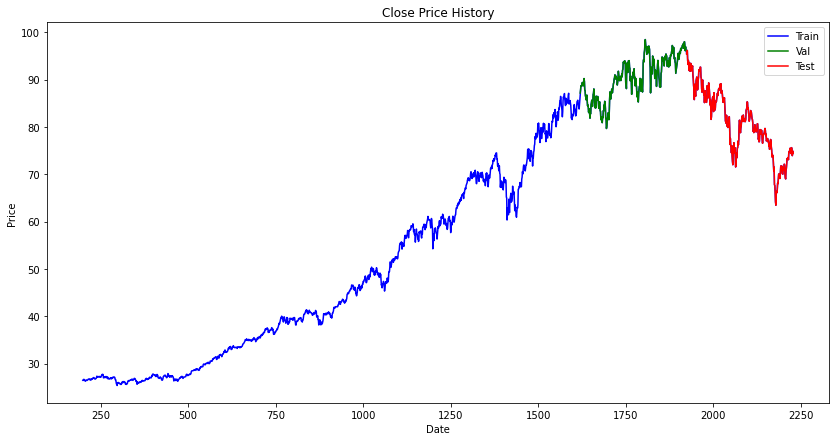

In [11]:
# plot line graph of price for entire df, price column is df['Close']
last_15_percent_index = int(len(df) * 0.85)
last_30_percent_index = int(len(df) * 0.70)

plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Train', color='blue')
plt.plot(df['Close'].iloc[last_30_percent_index:last_15_percent_index], label='Val', color='green')
plt.plot(df['Close'].iloc[last_15_percent_index:], label='Test', color='red')
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

No handles with labels found to put in legend.


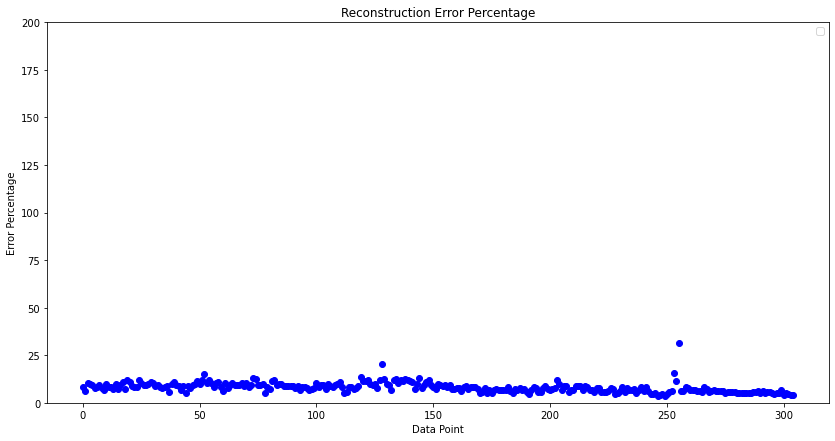

In [12]:
#   scatter graph to plot all errors, dont need to rearragne points
plt.figure(figsize=(14, 7))
plt.scatter(range(len(reconstruction_error_percentage)), reconstruction_error_percentage, color='blue')
plt.ylim(0, 200)
plt.title('Reconstruction Error Percentage')
plt.xlabel('Data Point')
plt.ylabel('Error Percentage')
plt.legend()
plt.show()



In [13]:
# error count frequency per range
error_ranges = [0, 1, 2, 5, 10, 20, 50, 100, 200]
error_counts = np.zeros(len(error_ranges) - 1)
for i in range(len(error_ranges) - 1):
    error_counts[i] = np.sum((reconstruction_error_percentage > error_ranges[i]) & (reconstruction_error_percentage <= error_ranges[i + 1]))
print(error_counts)


[  0.   0.  17. 236.  50.   2.   0.   0.]


In [14]:
# print with descriptino
for i in range(len(error_ranges) - 1):
    print(f'Error percentage between {error_ranges[i]} and {error_ranges[i + 1]}: {error_counts[i]}')

Error percentage between 0 and 1: 0.0
Error percentage between 1 and 2: 0.0
Error percentage between 2 and 5: 17.0
Error percentage between 5 and 10: 236.0
Error percentage between 10 and 20: 50.0
Error percentage between 20 and 50: 2.0
Error percentage between 50 and 100: 0.0
Error percentage between 100 and 200: 0.0


In [15]:
#sum error count
np.sum(error_counts)

305.0

In [16]:
len(X_test)

305

In [17]:
# remove top 10 highest errors and get new error average without them
top_10_indices = np.argsort(reconstruction_error_percentage)[-10:]
top_10_indices

# remove from reconstruction_error_percentages
reconstruction_error_percentage_no_top_10 = np.delete(reconstruction_error_percentage, top_10_indices)

print(f'Original Error Percentage Mean: {reconstruction_error_percentage_mean}')
print(f'Error Percentage Mean Without Top 10: {np.mean(reconstruction_error_percentage_no_top_10)}')


Original Error Percentage Mean: 8.128896433191747
Error Percentage Mean Without Top 10: 7.862469061603534


In [18]:
# get cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarities  = np.diag(cosine_similarity(X_test, reconstructed_test))

# get some statistics on the cosine similarities
cosine_similarities_mean = np.mean(cosine_similarities)
cosine_similarities_std = np.std(cosine_similarities)
cosine_similarities_min = np.min(cosine_similarities)
cosine_similarities_max = np.max(cosine_similarities)

print(f'Cosine Similarity Mean: {cosine_similarities_mean}')
print(f'Cosine Similarity Std: {cosine_similarities_std}')
print(f'Cosine Similarity Min: {cosine_similarities_min}')
print(f'Cosine Similarity Max: {cosine_similarities_max}')


Cosine Similarity Mean: 0.9951422109676619
Cosine Similarity Std: 0.002285988145130292
Cosine Similarity Min: 0.9778978398311662
Cosine Similarity Max: 0.9987618313445765


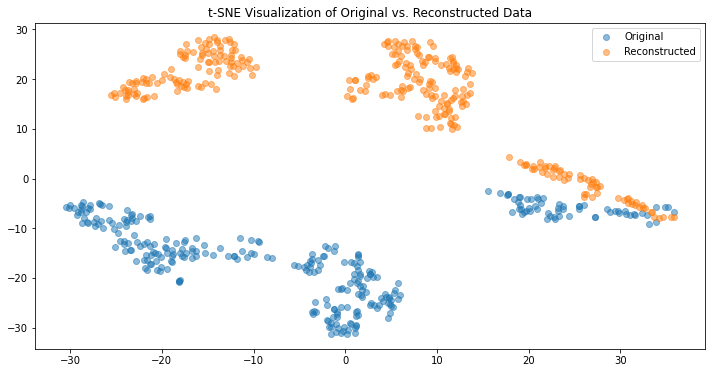

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Combine original and reconstructed vectors
X_combined = np.vstack([X_test, reconstructed_test])
labels = ["Original"] * len(X_test) + ["Reconstructed"] * len(reconstructed_test)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_combined)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(X_tsne[:len(X_test), 0], X_tsne[:len(X_test), 1], label="Original", alpha=0.5)
plt.scatter(X_tsne[len(X_test):, 0], X_tsne[len(X_test):, 1], label="Reconstructed", alpha=0.5)
plt.legend()
plt.title("t-SNE Visualization of Original vs. Reconstructed Data")
plt.show()


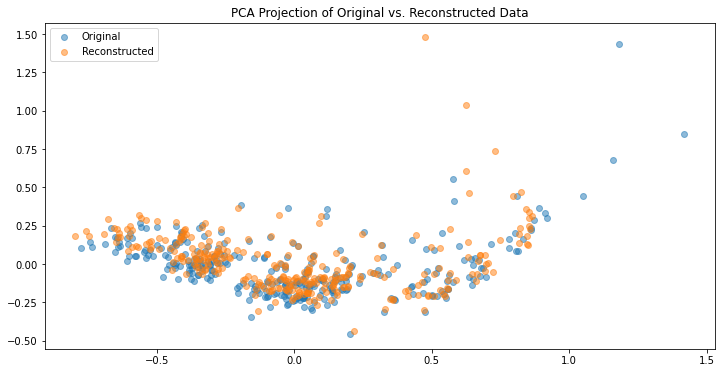

In [20]:
from sklearn.decomposition import PCA

X_combined = np.vstack([X_test, reconstructed_test])

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(X_pca[:len(X_test), 0], X_pca[:len(X_test), 1], label="Original", alpha=0.5)
plt.scatter(X_pca[len(X_test):, 0], X_pca[len(X_test):, 1], label="Reconstructed", alpha=0.5)
plt.legend()
plt.title("PCA Projection of Original vs. Reconstructed Data")
plt.show()


In [21]:
for i in range (50,100):
    print(f'Index: {i}')
    calculate_index_error_percentage(i, X_test, reconstructed_test)

Index: 50
9.863867282484321
Index: 51
11.97487908881636
Index: 52
15.16052019741309
Index: 53
10.623382479109772
Index: 54
11.751514299413303
Index: 55
10.570285272284007
Index: 56
8.500947795311015
Index: 57
10.668854779450964
Index: 58
10.993641880194195
Index: 59
8.474976187679626
Index: 60
6.251873718749914
Index: 61
10.610452896856462
Index: 62
7.63702526697527
Index: 63
9.239040264477518
Index: 64
10.491069283254527
Index: 65
9.567491621714591
Index: 66
9.32969930689576
Index: 67
9.32558671761349
Index: 68
10.362742339321285
Index: 69
8.988742327560928
Index: 70
10.246416344411674
Index: 71
8.126498361197239
Index: 72
9.214275733290377
Index: 73
13.064258982937634
Index: 74
12.302495627642228
Index: 75
9.272834423597704
Index: 76
9.107755913094708
Index: 77
9.884552998252904
Index: 78
5.317008481586153
Index: 79
8.180964255487417
Index: 80
7.021166566129813
Index: 81
11.362580609453278
Index: 82
11.837903190400501
Index: 83
9.405240400976709
Index: 84
9.935851233195457
Index: 85


In [22]:
from numpy.linalg import norm

euclidean_dist = np.mean([norm(X_test[i] - reconstructed_test[i]) for i in range(len(X_test))])
print(f"Average Euclidean Distance: {euclidean_dist:.4f}")

relative_error = euclidean_dist / np.mean(np.linalg.norm(X_test, axis=1))
print(f"Relative Euclidean Error: {relative_error:.4f}")



Average Euclidean Distance: 0.3043
Relative Euclidean Error: 0.0969
